# Import Libraries

In [14]:
import sys
import sqlite3
import warnings

import pandas as pd
import numpy as np

import optuna
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier # Changed from ExtraTreesClassifier
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFECV


warnings.filterwarnings('ignore')
np.random.seed(42)

# Load Database

In [2]:
sys.path.append('/home/pooya/w/DroughtMonitoringIran/')

DATABASE_PATH = "./database/database.db"

conn = sqlite3.connect(DATABASE_PATH)

data = pd.read_sql(sql='SELECT * FROM data', con=conn)

conn.close()

# Select Columns and Rows

In [3]:
# Select Drought Index and Period
di = 'SPEI'
di_scale = 6

# Select Stations
# selected_stations = ['Ramsar', 'Nowshahr', 'Siahbisheh', 'Kiyasar', 'Kojur', 'Baladeh', 'Alasht', 'Babolsar', 'Gharakhil', 'Sari', 'Sari (dasht-e-naz airport)', 'Galugah', 'Bandar-e-amirabad', 'Amol', 'Polsefid']
selected_stations = ['Ramsar', 'Nowshahr']
# selected_stations = ['Siahbisheh', 'Kiyasar', 'Kojur', 'Baladeh', 'Alasht']
# selected_stations = ['Babolsar', 'Gharakhil', 'Sari', 'Sari (dasht-e-naz airport)', 'Galugah', 'Bandar-e-amirabad', 'Amol', 'Polsefid']

# Select Columns
selected_columns = [
    'Station_Name', 'Station_ID',
    'Station_Latitude', 'Station_Longitude', 'Station_Elevation',
    'Date',
    f'{di}_{di_scale}',
    f'GPM_{di}_{di_scale}',
    f'ERA5_{di}_{di_scale}',
    'ERA5_Precipitation',
    'GPM_Precipitation',
    'TRMM_Precipitation',
    'TERRACLIMATE_Precipitation',
    'PERSIANNCDR_Precipitation',
    'PET_MOD16A2GF',
    'NDVI', 'EVI',
    'LSTDay', 'LSTNight', 'LST',
    'PCI_GPM', 'PCI_ERA5',
    'VCI', 'TCI', 'VHI',
    'CI_GPM', 'CI_ERA5',
]

# Select Start and End Date
start_date = '2006-09'
end_date = '2023-10'

# Filter Data

In [4]:
df = data\
    .filter(items=selected_columns)\
        .query("Station_Name in @selected_stations and Date >= @start_date and Date < @end_date")

# Add Some Columns

In [5]:
# Date, Year, Month
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# SPI and SPEI Class
df[f'{di}_{di_scale}_Class'] = pd.cut(df[f'{di}_{di_scale}'], bins=[-10, -2, -1.5, -1, 1, 1.5, 2, 10], labels=['ED', 'SD', 'MD', 'NN', 'MW', 'VW', 'EW'])

# Month Sin & Cos
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
        
# LST Diff
df['LST_Diff'] = df['LSTDay'] - df['LSTNight']

# Convert to Category
df['Station_ID'] = df['Station_ID'].astype('category')
df['Year'] = df['Year'].astype('category')
df['Month'] = df['Month'].astype('category')
df[f'{di}_{di_scale}_Class'] = df[f'{di}_{di_scale}_Class'].astype('category')

In [6]:
df.dropna(inplace=True)
df.sort_values(by=['Station_ID', 'Year', 'Month'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [7]:
selected_columns_lag_roll = [
    'ERA5_Precipitation',
    'GPM_Precipitation',
    'TRMM_Precipitation',
    'TERRACLIMATE_Precipitation',
    'PERSIANNCDR_Precipitation',
    f'GPM_{di}_{di_scale}',
    f'ERA5_{di}_{di_scale}',
    'PET_MOD16A2GF',
    'NDVI', 'EVI',
    'LSTDay', 'LSTNight', 'LST',
    'PCI_GPM', 'PCI_ERA5',
    'VCI', 'TCI', 'VHI',
    'CI_GPM', 'CI_ERA5',
]

# Add Lag
for lag in range(1, 4):
    for col in selected_columns_lag_roll:
        df[f'{col}_lag_{lag}'] = df.groupby('Station_ID', observed=False)[col].shift(lag)


# Add Mean and Std Roll
for r in [3]:
    for col in selected_columns_lag_roll:
        df[f'{col}_roll_mean_{r}'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=r, min_periods=1).mean())
        df[f'{col}_roll_std_{r}'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=r, min_periods=1).std())

# Remove all NA

In [8]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Station-wise Standardization

In [9]:
# Define columns to exclude from features
EXCLUDE_COLS = ['Station_Name', 'Station_ID', 'Date', f'{di}_{di_scale}_Class', f'{di}_{di_scale}', 'Year', 'Month']
FEATURES = [col for col in df.columns if col not in EXCLUDE_COLS]

# Station-wise standardization
df_scaled = df.copy()
for station in df_scaled['Station_Name'].unique():
    station_mask = df_scaled['Station_Name'] == station
    scaler = StandardScaler()
    df_scaled.loc[station_mask, FEATURES] = scaler.fit_transform(df_scaled.loc[station_mask, FEATURES])


class_counts = df_scaled[f'{di}_{di_scale}_Class'].value_counts()
classes_to_remove = class_counts[class_counts < 2].index

if not classes_to_remove.empty:
    print(f"Removing classes with fewer than 2 samples: {classes_to_remove.tolist()}")
    
    # Filter the dataframe to exclude these rare classes
    df_filtered = df_scaled[~df_scaled[f'{di}_{di_scale}_Class'].isin(classes_to_remove)].copy()
    
    # Redefine X and y from the filtered dataframe
    X = df_filtered[FEATURES]
    y = df_filtered[f'{di}_{di_scale}_Class']
    
    print(f"Data shape after removing rare classes: {X.shape}")
    print("\n--- Final Class Distribution ---")
    print(y.value_counts())
else:
    print("No classes with fewer than 2 samples found.")
    X = df_scaled[FEATURES]
    y = df_scaled[f'{di}_{di_scale}_Class']

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.30,
    random_state=42,
    stratify=y_encoded
)

print(f"Target Classes: {le.classes_}")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Removing classes with fewer than 2 samples: ['EW']
Data shape after removing rare classes: (303, 126)

--- Final Class Distribution ---
SPEI_6_Class
NN    199
MD     37
MW     31
SD     20
VW     13
ED      3
EW      0
Name: count, dtype: int64
Target Classes: ['ED' 'MD' 'MW' 'NN' 'SD' 'VW']
Training set shape: (212, 126)
Testing set shape: (91, 126)


# Feature Selection with RFECV

Optimal number of features found: 16
Selected features: ['GPM_SPEI_6', 'ERA5_SPEI_6', 'GPM_Precipitation', 'TRMM_Precipitation', 'LSTDay_lag_3', 'VHI_lag_3', 'TRMM_Precipitation_roll_mean_3', 'GPM_SPEI_6_roll_mean_3', 'GPM_SPEI_6_roll_std_3', 'EVI_roll_std_3', 'LSTDay_roll_std_3', 'PCI_GPM_roll_mean_3', 'PCI_ERA5_roll_mean_3', 'VCI_roll_mean_3', 'CI_ERA5_roll_mean_3', 'CI_ERA5_roll_std_3']


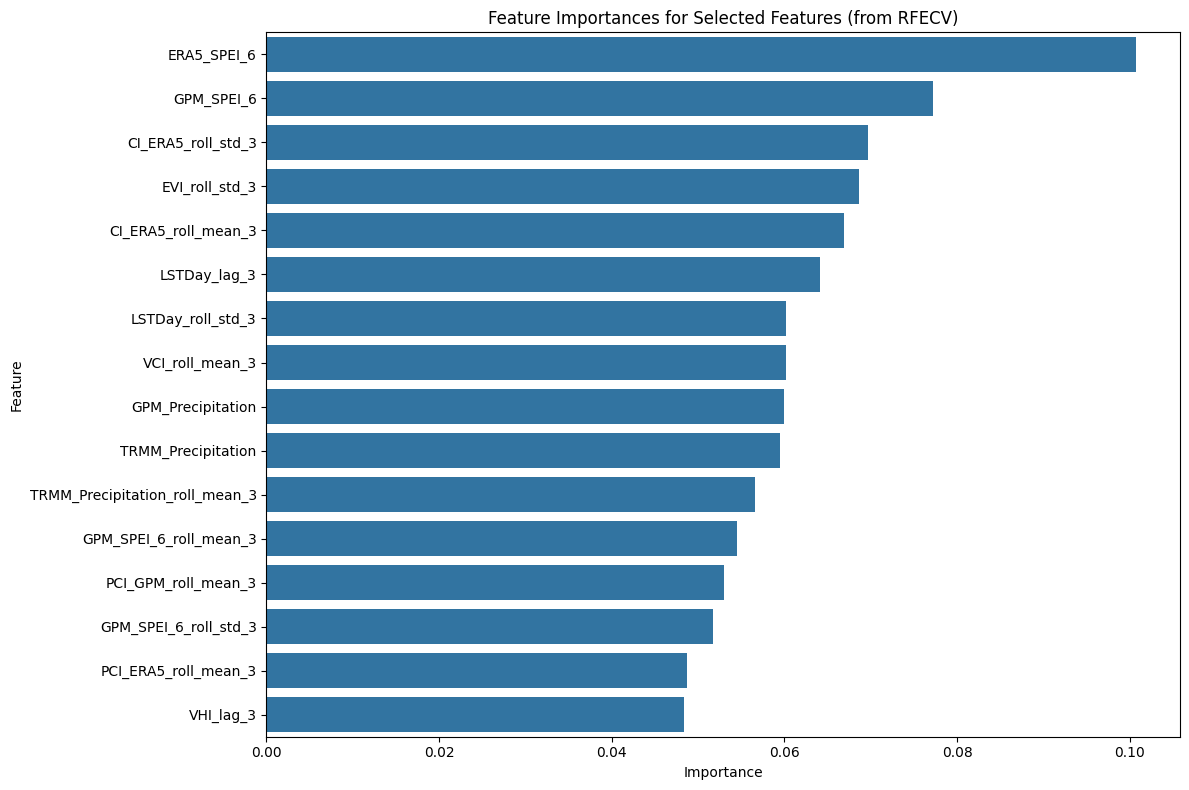

In [10]:
# The estimator that will be used by RFECV
estimator = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

# The RFECV object
rfecv = RFECV(
    estimator=estimator,
    step=1,
    cv=StratifiedKFold(5),
    scoring='f1_macro',
    n_jobs=-1
)

# Fit RFECV on the training data
rfecv.fit(X_train, y_train)

print(f"Optimal number of features found: {rfecv.n_features_}")

# Get the final selected features
final_features = X_train.columns[rfecv.support_]
print(f"Selected features: {final_features.tolist()}")

# --- Plot Feature Importances ---
# The `rfecv.estimator_` attribute is the model trained on the full set of features
# during the last step of the cross-validation process. We can use its feature importances.
importances = rfecv.estimator_.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': final_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot only the selected features
selected_feature_importances = feature_importance_df[feature_importance_df['Feature'].isin(final_features)]

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=selected_feature_importances)
plt.title('Feature Importances for Selected Features (from RFECV)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


# Update training and testing sets with selected features
X_train_final = X_train[final_features]
X_test_final = X_test[final_features]

# Hyperparameter Tuning with Optuna

In [11]:
def objective(trial):
    """Define the objective function for Optuna to optimize."""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'random_state': 42,
        'n_jobs': -1
    }
    
    model = RandomForestClassifier(**params)
    
    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []
    
    for train_idx, val_idx in skf.split(X_train_final, y_train):
        X_train_fold, X_val_fold = X_train_final.iloc[train_idx], X_train_final.iloc[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        
        model.fit(X_train_fold, y_train_fold)
        preds = model.predict(X_val_fold)
        f1_scores.append(f1_score(y_val_fold, preds, average='macro'))
        
    return np.mean(f1_scores)

# Create a study object and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, timeout=600) # 50 trials or 10 minutes

print(f"Best trial found: {study.best_trial.number}")
print(f"Best Macro-F1 Score: {study.best_value}")
print("Best Hyperparameters:")
print(study.best_params)


[I 2025-08-22 14:59:14,632] A new study created in memory with name: no-name-dde89972-5537-4bbd-ba17-484f869cadf1
[I 2025-08-22 14:59:18,004] Trial 0 finished with value: 0.2704799514211279 and parameters: {'n_estimators': 440, 'max_depth': 27, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 0.5010692997895781, 'criterion': 'gini'}. Best is trial 0 with value: 0.2704799514211279.
[I 2025-08-22 14:59:21,273] Trial 1 finished with value: 0.20494543843009314 and parameters: {'n_estimators': 424, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 10, 'max_features': 0.8315217971959337, 'criterion': 'gini'}. Best is trial 0 with value: 0.2704799514211279.
[I 2025-08-22 14:59:23,936] Trial 2 finished with value: 0.17045136635662267 and parameters: {'n_estimators': 358, 'max_depth': 44, 'min_samples_split': 13, 'min_samples_leaf': 14, 'max_features': 0.49331863680651145, 'criterion': 'gini'}. Best is trial 0 with value: 0.2704799514211279.
[I 2025-08-22 14:59:25,858] 

Best trial found: 76
Best Macro-F1 Score: 0.3315909226922008
Best Hyperparameters:
{'n_estimators': 115, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 0.7918866687293973, 'criterion': 'gini'}


# Model Training & Evaluation

Overall Accuracy: 0.7253
Macro-F1 Score: 0.3291
Cohen's Kappa: 0.3729

Classification Report:
              precision    recall  f1-score   support

          ED       0.00      0.00      0.00         1
          MD       0.67      0.55      0.60        11
          MW       0.50      0.22      0.31         9
          NN       0.76      0.95      0.84        60
          SD       0.33      0.17      0.22         6
          VW       0.00      0.00      0.00         4

    accuracy                           0.73        91
   macro avg       0.38      0.31      0.33        91
weighted avg       0.65      0.73      0.67        91


--- Plotting Confusion Matrix ---


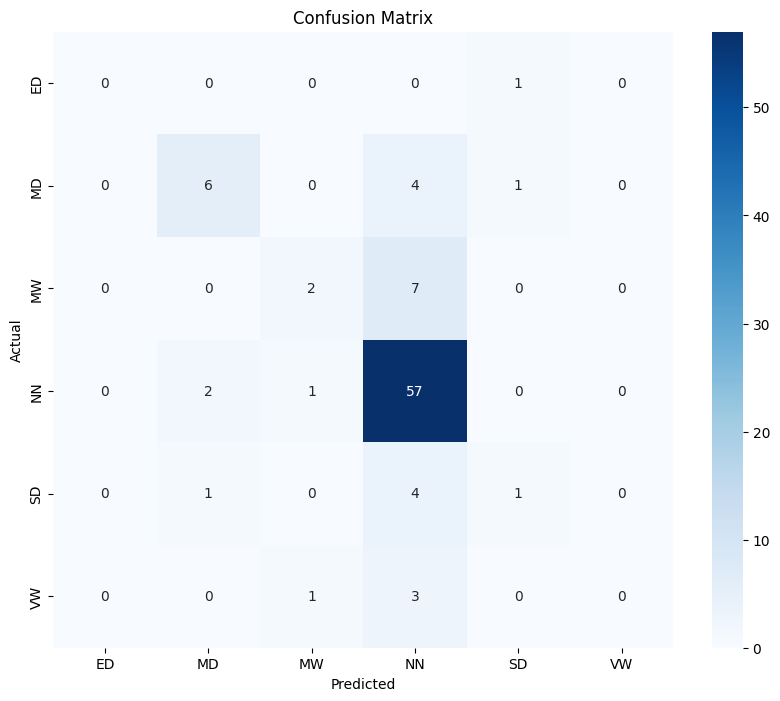

In [12]:
# Get best hyperparameters
best_params = study.best_params
best_params['random_state'] = 42
best_params['n_jobs'] = -1

# Train the final model
final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train_final, y_train)

# Make predictions on the test set
y_pred = final_model.predict(X_test_final)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
kappa = cohen_kappa_score(y_test, y_pred)

print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Macro-F1 Score: {macro_f1:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


# --- Plot Confusion Matrix ---
print("\n--- Plotting Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Explainability with SHAP


--- 5. SHAP Analysis and Reporting ---

Generating SHAP Summary Bar Plot...


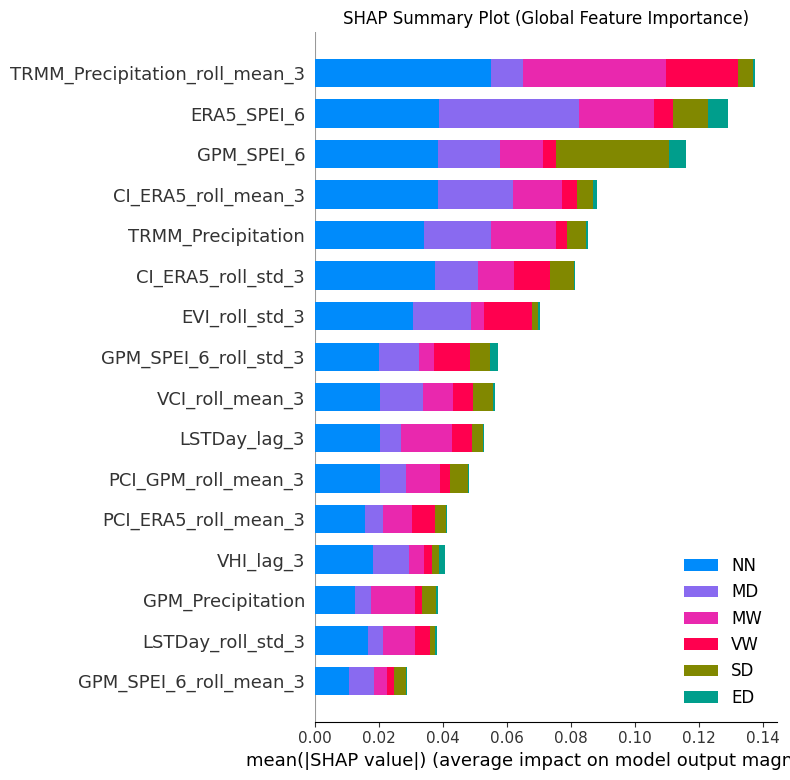


Generating SHAP Summary Beeswarm Plot...


<Figure size 640x480 with 0 Axes>

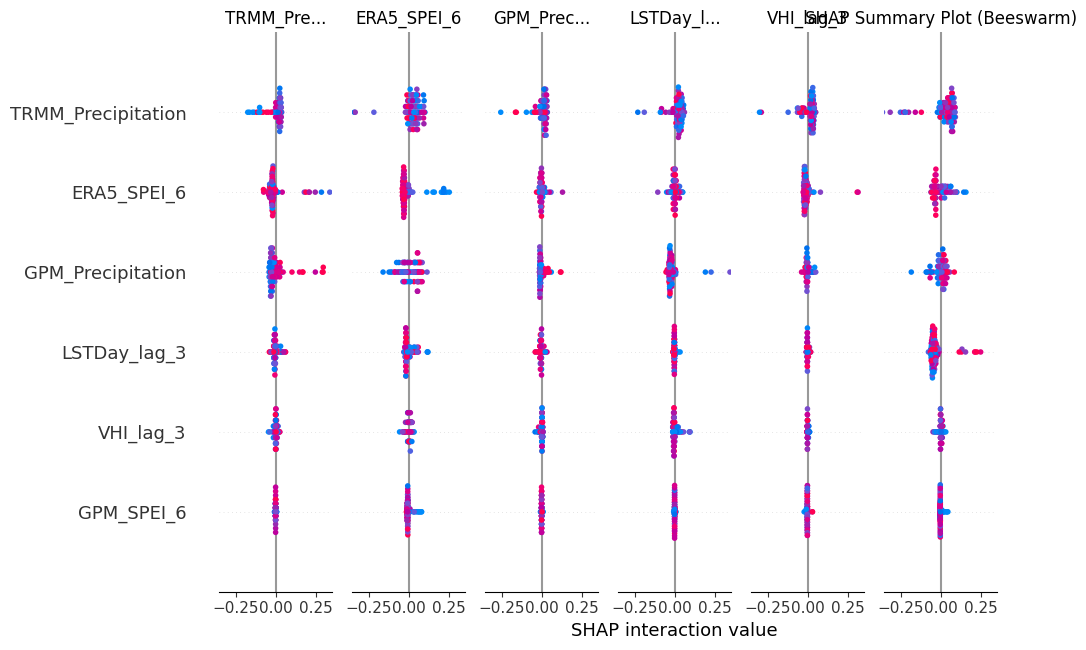

In [ ]:
# Create SHAP explainer for the final model
# Using a subset of the training data for the background is a common practice for performance
explainer = shap.TreeExplainer(final_model, X_train_final.sample(100, random_state=42))
shap_values = explainer.shap_values(X_test_final)

# SHAP Summary Plot (Bar)
print("\nGenerating SHAP Summary Bar Plot...")
plt.figure()
shap.summary_plot(shap_values, X_test_final, plot_type="bar", class_names=le.classes_, show=False)
plt.title("SHAP Summary Plot (Global Feature Importance)")
plt.tight_layout()
plt.show()

# SHAP Summary Plot (Beeswarm)
print("\nGenerating SHAP Summary Beeswarm Plot...")
plt.figure()
shap.summary_plot(shap_values, X_test_final, class_names=le.classes_, show=False,  plot_type="violin")
plt.title("SHAP Summary Plot (Beeswarm)")
plt.tight_layout()
plt.show()